In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy.sparse import hstack

In [3]:

fake = pd.read_csv('/home/rithwik/AI_ML/17_Weeks_of_Projects/Week_3_NLP_Fake_News/fake-news-detector/data/Fake.csv')
true = pd.read_csv('/home/rithwik/AI_ML/17_Weeks_of_Projects/Week_3_NLP_Fake_News/fake-news-detector/data/True.csv')

fake["label"] = 0   # adds a new column "label" - value 0 for fake news
true["label"] = 1   # same but value 1 for true news

df = pd.concat([fake, true], axis=0, ignore_index=True)  # concatenates both dataframes together vertically
df = df.sample(frac=1, random_state=42).reset_index(drop=True) # shuffles the dataframe to avoid order bias)
print ("Dataset shape:", df.shape)
print("\nHere are the first 5 rows of the dataframe:")
print (df.head())

Dataset shape: (44898, 5)

Here are the first 5 rows of the dataframe:
                                               title  \
0  Ben Stein Calls Out 9th Circuit Court: Committ...   
1  Trump drops Steve Bannon from National Securit...   
2  Puerto Rico expects U.S. to lift Jones Act shi...   
3   OOPS: Trump Just Accidentally Confirmed He Le...   
4  Donald Trump heads for Scotland to reopen a go...   

                                                text       subject  \
0  21st Century Wire says Ben Stein, reputable pr...       US_News   
1  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...  politicsNews   
3  On Monday, Donald Trump once again embarrassed...          News   
4  GLASGOW, Scotland (Reuters) - Most U.S. presid...  politicsNews   

                  date  label  
0    February 13, 2017      0  
1       April 5, 2017       1  
2  September 27, 2017       1  
3         May 22, 2017      0  
4       Jun

In [4]:
print("Columns in the dataset:", df.columns.tolist())
print("\nNumber of missing values in each column:", df.isnull().sum())


Columns in the dataset: ['title', 'text', 'subject', 'date', 'label']

Number of missing values in each column: title      0
text       0
subject    0
date       0
label      0
dtype: int64



Text Length In Characters:
 count    44898.000000
mean      2469.109693
std       2171.617091
min          1.000000
25%       1234.000000
50%       2186.000000
75%       3105.000000
max      51794.000000
Name: text_length_chars, dtype: float64

Text Length In Words:
 count    44898.000000
mean       405.282284
std        351.265595
min          0.000000
25%        203.000000
50%        362.000000
75%        513.000000
max       8135.000000
Name: text_length_words, dtype: float64


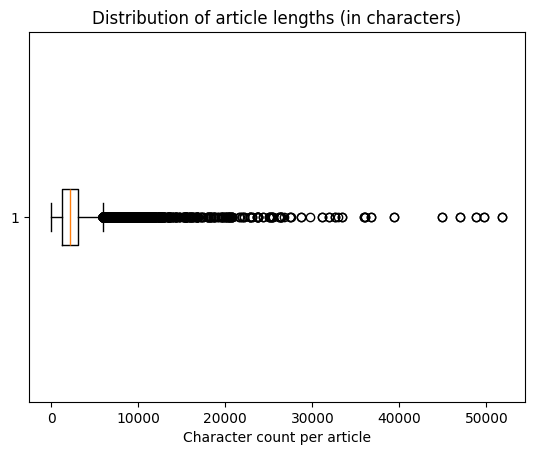

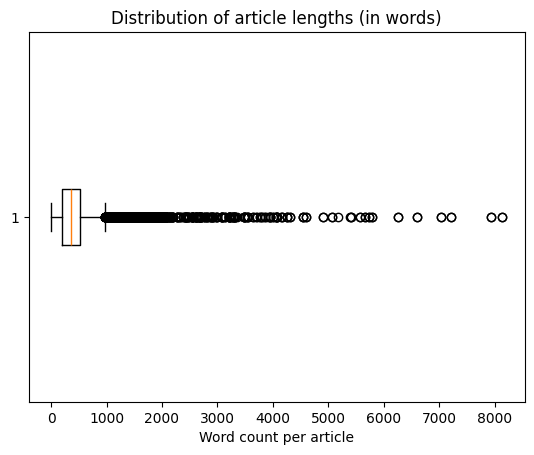

In [5]:
df['text_length_chars'] = df['text'].str.len() # Character count of each article added to a new column


df['text_length_words'] = df['text'].str.split().str.len() # Word count of each article added to a new column

print("\nText Length In Characters:\n", df['text_length_chars'].describe())

print("\nText Length In Words:\n", df['text_length_words'].describe())

# Box Plot to visualize distribution of text_length_chars
plt.boxplot(df['text_length_chars'], vert=False)
plt.xlabel('Character count per article')
plt.title('Distribution of article lengths (in characters)')
plt.show()


# Box Plot to visualize distribution of text_length_words
plt.boxplot(df['text_length_words'], vert=False)
plt.xlabel('Word count per article')
plt.title('Distribution of article lengths (in words)')
plt.show()

In [6]:

# Check for empty or junk articles

# Count how many rows have completely empty text
print("Articles with no text:", (df['text'].str.strip() == '').sum())

# Count how many rows contain URLs (could be junk articles like "http://... only")
print("Articles with only URLs:", df['text'].str.contains(r'http[s]?://', na=False).sum())

# Peek at very short articles (between 1 and 20 words) which are often too small to be useful
print("\nVery short articles (between 1 and 20 words):")
print(df[(df['text_length_words'] > 0) & (df['text_length_words'] <= 20)][['title', 'text', 'text_length_words']].head(10))
print("\nNumber of articles between 1 and 20 words:", ((df['text_length_words'] > 0) & (df['text_length_words'] <= 20)).sum())

Articles with no text: 631
Articles with only URLs: 3299

Very short articles (between 1 and 20 words):
                                                  title  \
371   WATCH TREY GOWDY Crush The Lying Media During ...   
407   UNREAL! CNN PANEL Laughs And Mocks Dr. Ben Car...   
573   PRICELESS! DON’T EVEN THINK About Calling This...   
639   One Picture At Miami Debate Watch Party For Je...   
648   THIS ONE IS SPOT ON! The Democrat Party In a N...   
823   BREAKING PHOTOS AND VIDEO: TRUMP AT THE MEXICA...   
878   OH LOOK! New Yorkers Don’t Hate Trump As Much ...   
936   WHILE WE’RE DEBATING CRUZ VS TRUMP: Listen To ...   
1004  LOL! HILLARY ACCIDENTALLY Calls Trump Her “Hus...   
1177  WOW! VIDEO SURFACES OF BERNIE SANDERS Praising...   

                                                   text  text_length_words  
371   This is awesome! I watched the entire press co...                 17  
407         https://www.youtube.com/watch?v=_FNt3ns_EGA                  1  
573   Watch as 

In [7]:
# Check for very long articles (over 5000 words)
print("\nVery long articles (over 5000 words):")
print(df[df['text_length_words'] > 5000][['title', 'text', 'text_length_words']].head(10))
print("\nNumber of articles over 5000 words:", (df['text_length_words'] > 5000).sum())


Very long articles (over 5000 words):
                                                   title  \
429            YEAR IN REVIEW: 2017 Top Ten Conspiracies   
2354   CLOAKED IN CONSPIRACY: Overview of JFK Files R...   
2529   The Las Vegas Mass Shooting – More to the Stor...   
3830   The Las Vegas Mass Shooting – More to the Stor...   
5923   WOW! AMERICA IS UNDER ATTACK By These 187 Orga...   
6016   ANTI-AMERICAN GEORGE SOROS Locks Arms With NFL...   
8083   ORLANDO ‘KNOWN WOLF’ Watched by FBI, Worked wi...   
9033   A MUST READ! Here’s Why Voting For DONALD TRUM...   
10937  MEDIA TRIPWIRE? Ping Pong Pizza Conspiracy Pro...   
11969  CULT CRIMES, MASS SHOOTINGS & MEDIA MIND CONTR...   

                                                    text  text_length_words  
429    Patrick Henningsen and Shawn Helton 21st Centu...               5797  
2354   Shawn Helton 21st Century WireSince late Octob...               5657  
2529   Shawn Helton 21st Century WireAlthough many ar...          


Title Length (in words):
count    44898.000000
mean        12.453472
std          4.111476
min          1.000000
25%         10.000000
50%         11.000000
75%         14.000000
max         42.000000
Name: title_length_words, dtype: float64


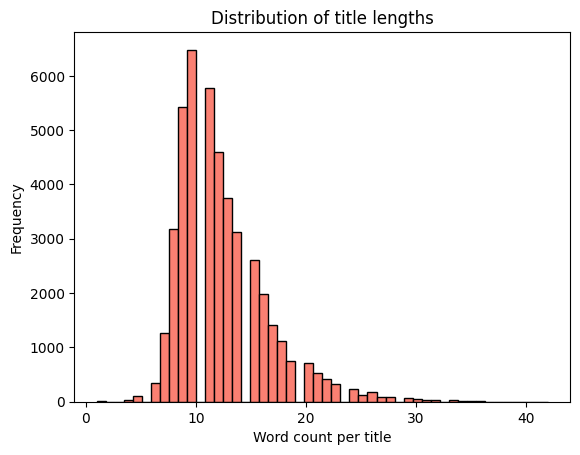


Titles with less than 3 words:
6408     https://100percentfedup.com/video-hillary-aske...
7367     https://fedup.wpengine.com/wp-content/uploads/...
9276     https://fedup.wpengine.com/wp-content/uploads/...
10886    https://100percentfedup.com/served-roy-moore-v...
15485    https://fedup.wpengine.com/wp-content/uploads/...
19300                                             Homepage
25820    https://100percentfedup.com/12-yr-old-black-co...
26402    https://fedup.wpengine.com/wp-content/uploads/...
27725    https://fedup.wpengine.com/wp-content/uploads/...
40812    https://fedup.wpengine.com/wp-content/uploads/...
Name: title, dtype: object

 Number of titles with less than 3 words: 10


In [8]:
# Explore title lengths (clickbait signal?)

# Compute title lengths (in words)
df['title_length_words'] = df['title'].str.split().str.len()

# Basic statistics about title lengths
print("\nTitle Length (in words):")
print(df['title_length_words'].describe())

# Visualize distribution of title lengths
plt.hist(df['title_length_words'], bins=50, color='salmon', edgecolor='black')
plt.xlabel('Word count per title')
plt.ylabel('Frequency')
plt.title('Distribution of title lengths')
plt.show()


# show the titles that have less than 3 words
print("\nTitles with less than 3 words:")
print(df[df['title_length_words'] < 3]['title'].head(10))
print("\n Number of titles with less than 3 words:", (df['title_length_words'] < 3).sum())


In [9]:


# Check for duplicate titles or texts

# Count duplicate titles (different rows with same title)
dup_titles = df.duplicated(subset=['title']).sum()

# Count duplicate texts (different rows with same article body)
dup_texts = df.duplicated(subset=['text']).sum()

print(f"Duplicate titles: {dup_titles}")
print(f"Duplicate texts: {dup_texts}")

# Show some examples of duplicate titles and their texts
print("\nExamples of duplicate articles:")
print(df[df.duplicated(subset=['title'], keep=False)][['title', 'text']].head(10))

Duplicate titles: 6169
Duplicate texts: 6252

Examples of duplicate articles:
                                                title  \
0   Ben Stein Calls Out 9th Circuit Court: Committ...   
7   STAND UP AND CHEER! UKIP Party Leader SLAMS Ge...   
21  BOOM! KELLYANNE CONWAY Schools CNN’s Anderson ...   
33  OUCH! NEW EMAILS Show Hillary Didn’t Want To F...   
34  China urges North Korea not to go further in a...   
37  #CrookedHillary Uses Twitter To Accuse Trump O...   
41  WHOA! RUSH LIMBAUGH RIPS Into Republicans Who ...   
42  WATCH: AMAZING THING HAPPENED When H.S. Valedi...   
45  ELEMENTARY SCHOOL PLANS ‘BLACKS ONLY’ FIELD TR...   
56  WATCH: SEAN HANNITY FANS Make HILARIOUS Videos...   

                                                 text  
0   21st Century Wire says Ben Stein, reputable pr...  
7   He s been Europe s version of the outspoken Te...  
21  Kellyanne Conway went at it with Anderson Coop...  
33  Former Secretary of State Hillary Clinton once...  
34  UNITED NAT

### Data Exploration Findings

1. **Dataset Overview**:
   - Combined dataset shape: Mix of fake and true news articles
   - No missing values in any columns

2. **Article Length Analysis**:
   - Text length varies significantly (both in characters and words)
   - Distribution shows presence of both very short and very long articles

3. **Data Quality Issues**:
   - Empty articles: Found articles with no text
   - URL-only content: Some articles contain only URLs
   - Very short articles (1-20 words): Could be problematic for analysis
   - Very long articles (>5000 words): Small number of outliers present

4. **Title Analysis**:
   - Title lengths show variation in distribution
   - Some titles are very short (less than 3 words) or are just URLS
   - Could be indicative of clickbait patterns

5. **Duplicate Content**:
   - Found duplicate titles and texts in the dataset
   - This suggests potential data redundancy

In [10]:
# Crosstab of subject vs label counts 
subject_label_counts = pd.crosstab(df['subject'], df['label'])
print("Crosstab of subject vs label counts:")
print(subject_label_counts)
# Normalize to percentages per subject 
subject_label_pct = subject_label_counts.div(subject_label_counts.sum(axis=1), axis=0) * 100
print("Percentage distribution of labels within each subject:")
print(subject_label_pct.round(2))

Crosstab of subject vs label counts:
label               0      1
subject                     
Government News  1570      0
Middle-east       778      0
News             9050      0
US_News           783      0
left-news        4459      0
politics         6841      0
politicsNews        0  11272
worldnews           0  10145
Percentage distribution of labels within each subject:
label                0      1
subject                      
Government News  100.0    0.0
Middle-east      100.0    0.0
News             100.0    0.0
US_News          100.0    0.0
left-news        100.0    0.0
politics         100.0    0.0
politicsNews       0.0  100.0
worldnews          0.0  100.0


### Baseline Model Tests: How Much Can Simple Features Predict?

In this step, we run three baseline models to understand how much predictive power comes from different features in the dataset:

1. **Model A: Subject Only**  
    - Uses only the `subject` column (one-hot encoded) to predict the label.
    - Purpose: Test for **data leakage**—if the model achieves perfect accuracy, it means `subject` directly reveals the label and must be dropped from further modeling.

2. **Model B: Title Only**  
    - Uses only the article `title`, transformed with TF-IDF vectorization.
    - Purpose: Measures how much information about fake/real news is present in the titles alone (e.g., clickbait patterns, source-specific language).

3. **Model C: Text Only**  
    - Uses only the article `text`, also with TF-IDF features.
    - Purpose: Evaluates the predictive power of the full article content.

For each model, we train a logistic regression classifier and evaluate its accuracy on a held-out test set.  
This helps us identify features that may leak label information and sets a baseline for more advanced models.


In [11]:


# --- Helper function ---
def train_and_evaluate(X, y, model_name, vectorizer=None):
    """
    Train Logistic Regression on given features X and labels y.
    Optionally apply a vectorizer (e.g., TF-IDF) to raw text.
    Returns accuracy score.
    """
    if vectorizer:
        X = vectorizer.fit_transform(X)

    # Split data once per model for fair comparison
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(f"\n=== {model_name} ===")
    print(classification_report(y_test, y_pred, digits=3))
    acc = (y_test == y_pred).mean()
    print(f"Accuracy: {acc:.3f}")
    return acc

# --- Run all models ---
results = {}

# Model A: subject only
X_subject = pd.get_dummies(df['subject'])
results["Subject only"] = train_and_evaluate(X_subject, df['label'], "Model A (subject)")

# Model B: title only
results["Title only"] = train_and_evaluate(
    df['title'], df['label'], "Model B (title)",
    vectorizer=TfidfVectorizer(max_features=5000, stop_words='english')
)

# Model C: text only
results["Text only"] = train_and_evaluate(
    df['text'], df['label'], "Model C (text)",
    vectorizer=TfidfVectorizer(max_features=5000, stop_words='english')
)

# --- Final comparison ---
print("\n=== Model Comparison ===")
comparison = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])
print(comparison.sort_values(by="Accuracy", ascending=False).round(3))



=== Model A (subject) ===
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      4696
           1      1.000     1.000     1.000      4284

    accuracy                          1.000      8980
   macro avg      1.000     1.000     1.000      8980
weighted avg      1.000     1.000     1.000      8980

Accuracy: 1.000

=== Model B (title) ===
              precision    recall  f1-score   support

           0      0.955     0.935     0.945      4696
           1      0.931     0.951     0.941      4284

    accuracy                          0.943      8980
   macro avg      0.943     0.943     0.943      8980
weighted avg      0.943     0.943     0.943      8980

Accuracy: 0.943

=== Model C (text) ===
              precision    recall  f1-score   support

           0      0.991     0.983     0.987      4696
           1      0.981     0.990     0.986      4284

    accuracy                          0.986      8980
   macro avg      0.

## Leakage Test & Baseline Results

As part of our dataset inspection, we ran three simple baseline models to test whether certain features leak label information:

- **Model A (subject only):**  Achieved **100% accuracy**, showing that the `subject` column directly reveals the label.  
  This is a clear case of **data leakage**: certain subjects (e.g., *left-news*, *worldnews*) map exclusively to either *fake* or *real* news.  
  → We must **drop `subject`** from all serious modeling.

- **Model B (title only):**  Accuracy ~ **94%** using only TF-IDF features of titles.  
- **Model C (text only):**  Accuracy ~ **98%** using TF-IDF features of the article body.

### Key Takeaways
1. **Subject column leaks labels.** A model can “cheat” and perfectly predict outcomes from `subject` alone.  
2. **Titles and texts yield very high scores** (94–98%) even with a simple logistic regression:
   - Fake and real news likely come from **different sources**, so models learn *source-specific vocabulary* rather than true fact vs. fake reasoning.  
   - Stylistic artifacts (clickbait language, topic distribution, writing style) provide strong signals.  
3. **Logistic regression + TF-IDF is very powerful** when the dataset contains strong lexical cues. Complex deep learning models are not strictly necessary here.  
4. These high results **do not generalize** to the real world. In practice, fake news detection is much harder, since there’s no guarantee of neat lexical or stylistic differences.

### Next Steps
- Remove `subject` to avoid leakage.  
- Treat current results as a **sanity check**, not a solved problem.  
- Consider stress-testing by:
  - Splitting train/test by **source** rather than random rows.  
  - Evaluating on an **external dataset**.  

This exercise highlights why **understanding the dataset** is as important as building models.


In [12]:
# ========================================================================
# Remove 'subject' column to avoid leakage, and perform final cleaning
# ========================================================================

# Drop the subject column completely
if 'subject' in df.columns:
    df = df.drop('subject', axis=1)
    print("'subject' column removed to prevent data leakage.")
else:
    print("'subject' column already removed.")

# Check dataset shape after removal
print("\nDataset shape after dropping 'subject':", df.shape)

# Re-check column names
print("Remaining columns:", df.columns.tolist())

'subject' column removed to prevent data leakage.

Dataset shape after dropping 'subject': (44898, 7)
Remaining columns: ['title', 'text', 'date', 'label', 'text_length_chars', 'text_length_words', 'title_length_words']


In [13]:
# Remove articles with no text
print("Shape before removing articles with no text:", df.shape)

print("\nNumber of articles with no text before removal:", (df['text'].str.strip() == '').sum())

df = df[df['text'].str.strip() != '']
print("\nDataset shape after removing articles with no text:", df.shape)

Shape before removing articles with no text: (44898, 7)

Number of articles with no text before removal: 631

Dataset shape after removing articles with no text: (44267, 7)


In [14]:
# Remove articles with only URLs as the text
print("Dataset shape before removing articles with only URLs as text:", df.shape)
print("Number of articles with only URLs as the text:", df['text'].str.contains(r'^\s*http[s]?://\S+\s*$', na=False).sum())

# Remove these junk articles
df = df[~df['text'].str.contains(r'^\s*http[s]?://\S+\s*$', na=False)]
print("\nDataset shape after removing articles with only URLs as text:", df.shape)

print("\nNumber of articles with only URLs as text after removal:", df['text'].str.contains(r'^\s*http[s]?://\S+\s*$', na=False).sum())

Dataset shape before removing articles with only URLs as text: (44267, 7)
Number of articles with only URLs as the text: 84

Dataset shape after removing articles with only URLs as text: (44183, 7)

Number of articles with only URLs as text after removal: 0


In [15]:
# Remove duplicate titles and texts
print("Dataset shape before removing duplicate titles and texts:", df.shape)
print("Number of duplicate titles before removal:", df.duplicated(subset=['title']).sum())

# Drop duplicate titles and texts
df = df.drop_duplicates(subset=['title'])

print("\nNumber of duplicate texts before removal:", df.duplicated(subset=['text']).sum())
df = df.drop_duplicates(subset=['text'])
print("\nDataset shape after removing duplicate titles and texts:", df.shape)

Dataset shape before removing duplicate titles and texts: (44183, 7)
Number of duplicate titles before removal: 5954

Number of duplicate texts before removal: 14

Dataset shape after removing duplicate titles and texts: (38215, 7)


In [ ]:
# Remove articles with a title length of less than 3 words
print("Dataset shape before removing articles with very short titles:", df.shape)
print("Number of articles with title length less than 3 words:", (df['title_length_words'] < 3).sum())
df = df[df['title_length_words'] > 3]
print("Dataset shape after removing articles with very short titles:", df.shape)

Dataset shape before removing articles with very short titles: (38215, 7)
Number of articles with title length less than 3 words: 1
Dataset shape after removing articles with very short titles: (38213, 7)


In [ ]:
# Remove articles with text length less than 20 words
print("Dataset shape before removing articles with very short text:", df.shape)
print("Number of articles with text length less than 20 words:", (df['text_length_words'] < 20).sum())
df = df[df['text_length_words'] >= 20]
print("Dataset shape after removing articles with very short text:", df.shape)
print("\nFinal dataset shape after all cleaning steps:", df.shape)

Dataset shape before removing articles with very short text: (38213, 7)
Number of articles with text length less than 20 words: 308
Dataset shape after removing articles with very short text: (37905, 7)

Final dataset shape after all cleaning steps: (37905, 7)


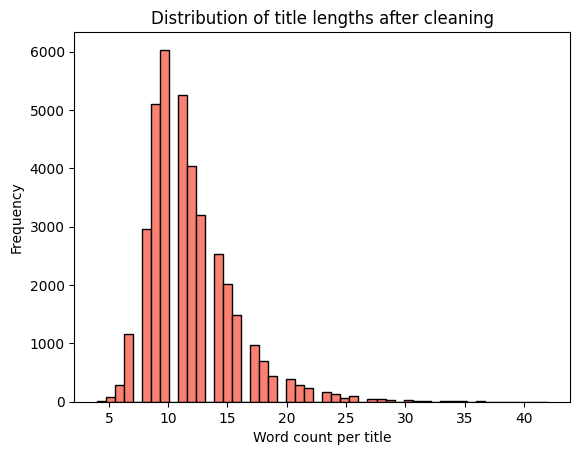

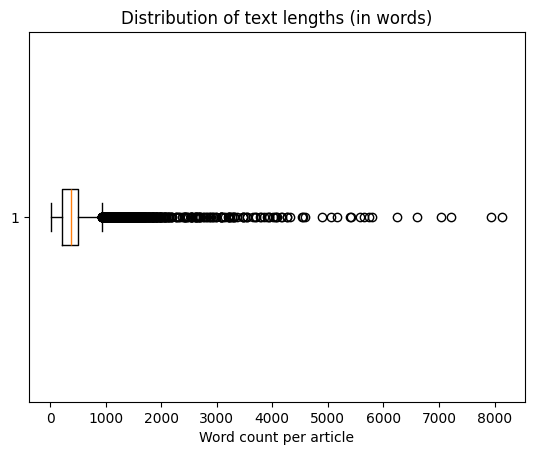

In [ ]:
# Final Visualizations after cleaning

# Visualize distribution of title lengths after cleaning
plt.hist(df['title_length_words'], bins=50, color='salmon', edgecolor='black')
plt.xlabel('Word count per title')
plt.ylabel('Frequency')
plt.title('Distribution of title lengths after cleaning')
plt.show()

# Visualize distribution of text lengths after cleaning
plt.boxplot(df['text_length_words'], vert=False)
plt.xlabel('Word count per article')
plt.title('Distribution of text lengths (in words)')
plt.show()

In [ ]:
# Show articles with short texts (less than 30 words)
print("\nArticles with less than 30 words:")
print(df[df['text_length_words'] < 30][['title', 'text', 'text_length_words']].head(10))
print("\nNumber of articles with less than 30 words:", (df['text_length_words'] < 30).sum())



Articles with less than 30 words:
                                                  title  \
43    RAW VIDEO: HILLARY AND BILL CLINTON DANCIN’ AN...   
182   SICKENING: SOROS’ PROTESTERS Block U.S. Air Fo...   
267   FIRE THIS WOMAN! RANTING NYU PROFESSOR GOES AP...   
326   BEST EVER CROOKED HILLARY Collection Of Lies A...   
359   YIKES! RICK PERRY On Dancing With The Stars…Ho...   
372   REAGAN’S WARNING TO US: “Those Voices Don’t Sp...   
866   STUNNING GRAPHIC Of Obama’s Legacy That Every ...   
1147  BRAVO! LAURA INGRAHAM DESTROYS JUAN WILLIAMS O...   
1281  (Video) Watch Presidential Candidate Donald Tr...   
1688  “STOP BLAMING WHITE PEOPLE For Trump’s Win Las...   

                                                   text  text_length_words  
43    Hillary has to be the absolute worst dancer ev...                 25  
182   #disruptj20 protesters blocking men in Air For...                 21  
267    Please RT until we identify this disgusting N...                 23  
326   H

In [ ]:
# Since some short articles arent really articles (they will behave like noise
# tweet-like entries, etc, can be removed:
print("\nDataset shape before removing tweet-like short articles:", df.shape)

# Heuristic to identify tweet-like short articles
import re

def looks_like_tweet(text):
    if len(text.split()) < 30:  # already short
        if re.search(r'http\S+|www\.\S+', text):  # links
            return True
        if re.search(r'@\w+', text):  # mentions
            return True
        if re.search(r'#\w+', text):  # hashtags
            return True
        if text.strip().startswith("RT "):  # retweet
            return True
        if sum(1 for w in text.split() if w.isupper()) / max(1, len(text.split())) > 0.6:
            return True  # mostly uppercase
        if re.search(r'\b(LOL|OMG|FYI|IDK|SMH|RT|BTW|TBH)\b', text, re.IGNORECASE):
            return True  # common internet slang
        
    return False

df["is_tweet_like"] = df["text"].apply(looks_like_tweet)
print("\nNumber of tweet-like short articles:", df["is_tweet_like"].sum())
print("\nHead of tweet-like articles:", df[df["is_tweet_like"]][['title', 'text']].head(10))


df = df[~df["is_tweet_like"]]  # drop them
print("\nDataset shape after removing tweet-like short articles:", df.shape)



Dataset shape before removing tweet-like short articles: (37905, 7)

Number of tweet-like short articles: 84

Head of tweet-like articles:                                                   title  \
182   SICKENING: SOROS’ PROTESTERS Block U.S. Air Fo...   
267   FIRE THIS WOMAN! RANTING NYU PROFESSOR GOES AP...   
1147  BRAVO! LAURA INGRAHAM DESTROYS JUAN WILLIAMS O...   
1688  “STOP BLAMING WHITE PEOPLE For Trump’s Win Las...   
2341  WATCH LIBERALS OPENLY MOCK Ann Coulter On TV F...   
2832  TUCKER CARLSON Calls Out Professor On His Clai...   
2902  WATCH: DIAMOND AND SILK Rip On John Kerry Over...   
3277  WATCH ANGRY TEACHER Play Out Mock Assassinatio...   
3473  AUDIENCE MEMBER GETS The Last Word When Michae...   
3708  WATCH: Only 6 People Show Up To See Hillary At...   

                                                   text  
182   #disruptj20 protesters blocking men in Air For...  
267    Please RT until we identify this disgusting N...  
1147  Vid: @IngrahamAngle decimates 

## Data Cleaning Summary

The following data cleaning steps have been performed in this notebook:

1. **Removal of Data Leakage Columns:**
   - The `subject` column was dropped after it was found to perfectly reveal the label, preventing data leakage in modeling.

2. **Handling Missing and Junk Content:**
   - Articles with empty and very short text fields (less than 20 words) were removed.
   - Articles containing only URLs in the text or title were identified and excluded.

3. **Duplicate Removal:**
   - Duplicate articles based on both `title` and `text` were dropped to reduce redundancy.

4. **Filtering by Length:**
   - Articles with very short titles (less than 3 words) were removed.

5. **Tweet-like and Noisy Content:**
   - Short articles resembling tweets (e.g., containing hashtags, mentions, excessive capitalization, or internet slang) were detected and removed using a heuristic.

6. **Final Dataset:**
   - After all cleaning steps, the dataset should contain mainly  substantive, non-duplicate, and non-noisy news articles.

These steps help us achieve higher data quality and try to prevent misleading model performance due to artifacts or noise in the dataset.


## Model Training Pipeline Objectives

The following code implements a comprehensive text classification pipeline designed to accomplish several key goals:

## Primary Objectives

**1. Build a Robust Text Classification Model**
- Train a logistic regression classifier on news articles using both title and text content
- Combine TF-IDF features from titles (5K features, 1-2 grams) and article text (10K features)
- Evaluate performance using classification reports and confusion matrices

**2. Prevent Data Leakage**
- Deduplicate articles based on combined title+text to avoid training/testing on identical content
- Maintain proper pairing of title and text during train/test splits
- Use stratified sampling to preserve class balance across splits

**3. Feature Engineering Excellence**
- Extract separate TF-IDF features from titles and article body text
- Leverage different n-gram ranges (unigrams + bigrams for titles, unigrams for text)
- Combine sparse feature matrices horizontally for comprehensive representation

## Validation & Stress Testing

**4. Standard Performance Baseline**
- Random 80/20 train/test split to establish baseline model performance
- Standard evaluation metrics to assess classification quality

**5. Generalization Stress Test**
- Implement source-based split using alphabetical title ordering as proxy for "unseen publishers"
- Test model robustness when exposed to completely different content sources
- Identify potential overfitting to specific writing styles or publication patterns

## Quality Assurance Goals

**6. Visual Performance Assessment**
- Generate confusion matrices with different color schemes for easy comparison
- Provide clear visual distinction between random split (Blues) and source split (Reds) results

**7. Leakage Detection**
- Compare performance between random and source-based splits to identify data leakage
- Significant performance drop in source split would indicate model is memorizing rather than learning generalizable patterns

This will allow the following pipeline to serve as both a production model trainer and a diagnostic tool for ensuring model reliability and generalizability.


Training final model on cleaned data...

=== Final Logistic Regression Model (Title + Text) ===
              precision    recall  f1-score   support

           0      0.992     0.982     0.987      3401
           1      0.986     0.993     0.989      4164

    accuracy                          0.988      7565
   macro avg      0.989     0.988     0.988      7565
weighted avg      0.988     0.988     0.988      7565



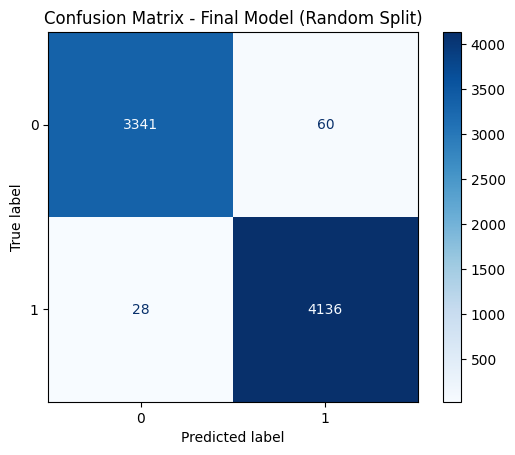


=== Stress Test: Source-Based Split (Unseen Titles Proxy) ===
              precision    recall  f1-score   support

           0      0.964     0.979     0.972      1548
           1      0.995     0.991     0.993      6017

    accuracy                          0.988      7565
   macro avg      0.980     0.985     0.982      7565
weighted avg      0.988     0.988     0.988      7565



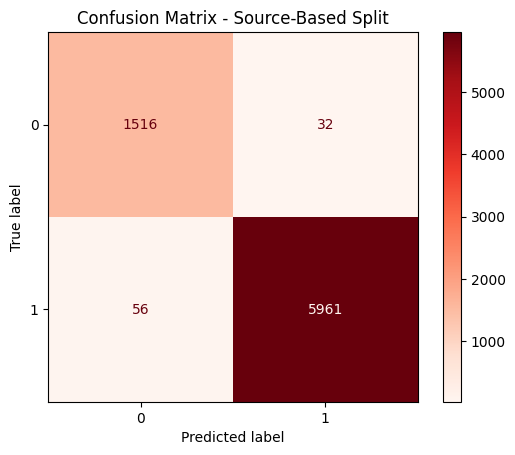

In [ ]:
# Train final model on cleaned data
print("\nTraining final model on cleaned data...")

# ========================================================================

# Careful Train/Test Split
# We ensure titles and texts are kept together and duplicates don’t leak.

# Remove any remaining duplicates just in case
df_unique = df.drop_duplicates(subset=['title', 'text'])

# Create features/labels
X_title = df_unique['title']
X_text = df_unique['text']
y = df_unique['label']

# Standard random split (baseline test) - keeps title/text paired
X_title_train, X_title_test, X_text_train, X_text_test, y_train, y_test = train_test_split(
    X_title, X_text, y, stratify=y, test_size=0.2, random_state=42
)

# Feature Engineering (TF-IDF on title & text separately)
tfidf_title = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
tfidf_text = TfidfVectorizer(max_features=10000, stop_words='english')

X_title_train_tfidf = tfidf_title.fit_transform(X_title_train)
X_title_test_tfidf = tfidf_title.transform(X_title_test)

X_text_train_tfidf = tfidf_text.fit_transform(X_text_train)
X_text_test_tfidf = tfidf_text.transform(X_text_test)

# Combine title + text features horizontally
X_train_combined = hstack([X_title_train_tfidf, X_text_train_tfidf])
X_test_combined = hstack([X_title_test_tfidf, X_text_test_tfidf])

# Step 3: Train Logistic Regression Model on combined features
clf = LogisticRegression(max_iter=2000)
clf.fit(X_train_combined, y_train)
y_pred = clf.predict(X_test_combined)

print("\n=== Final Logistic Regression Model (Title + Text) ===")
print(classification_report(y_test, y_pred, digits=3))

# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Final Model (Random Split)")
plt.show()

# ========================================================================
# Stress-Test: Source-Based Split (Leakage Check)
# ========================================================================

# For this test, we simulate "unseen publishers".
# Example: train on 80% of titles alphabetically, test on 20% unseen titles.

# Split by article index based on sorted titles
sorted_idx = df_unique.sort_values("title").index
cutoff = int(len(sorted_idx) * 0.8)

train_idx = sorted_idx[:cutoff]
test_idx = sorted_idx[cutoff:]

X_title_train_src, X_title_test_src = df_unique.loc[train_idx, "title"], df_unique.loc[test_idx, "title"]
X_text_train_src, X_text_test_src = df_unique.loc[train_idx, "text"], df_unique.loc[test_idx, "text"]
y_train_src, y_test_src = df_unique.loc[train_idx, "label"], df_unique.loc[test_idx, "label"]

# Vectorize separately
X_title_train_src_tfidf = tfidf_title.fit_transform(X_title_train_src)
X_title_test_src_tfidf = tfidf_title.transform(X_title_test_src)

X_text_train_src_tfidf = tfidf_text.fit_transform(X_text_train_src)
X_text_test_src_tfidf = tfidf_text.transform(X_text_test_src)

# Combine
X_train_src_combined = hstack([X_title_train_src_tfidf, X_text_train_src_tfidf])
X_test_src_combined = hstack([X_title_test_src_tfidf, X_text_test_src_tfidf])

# Train & evaluate
clf_src = LogisticRegression(max_iter=2000)
clf_src.fit(X_train_src_combined, y_train_src)
y_pred_src = clf_src.predict(X_test_src_combined)

print("\n=== Stress Test: Source-Based Split (Unseen Titles Proxy) ===")
print(classification_report(y_test_src, y_pred_src, digits=3))

cm_src = confusion_matrix(y_test_src, y_pred_src, labels=clf_src.classes_)
disp_src = ConfusionMatrixDisplay(confusion_matrix=cm_src, display_labels=clf_src.classes_)
disp_src.plot(cmap='Reds', values_format='d')
plt.title("Confusion Matrix - Source-Based Split")
plt.show()


# Get feature names for interpretation
title_features = [f"title_{word}" for word in tfidf_title.get_feature_names_out()]
text_features = [f"text_{word}" for word in tfidf_text.get_feature_names_out()]
all_features = title_features + text_features

# ========================================================================



Analyzing Random Split Model...

=== Random Split Model - Feature Importance Analysis ===

Top 10 features predicting Class 1 (positive coefficients):
  text_returned                  | Coef: 16.7213 | Type: text
  text_sahel                     | Coef: 16.3058 | Type: text
  text_washed                    | Coef: 5.3672 | Type: text
  text_representative            | Coef: 4.5031 | Type: text
  title_rule                     | Coef: 4.4206 | Type: title
  text_trust                     | Coef: 4.3587 | Type: text
  text_wedding                   | Coef: 4.2402 | Type: text
  text_throw                     | Coef: 3.8297 | Type: text
  title_expert                   | Coef: 3.6840 | Type: title
  text_freeze                    | Coef: 3.5613 | Type: text

Top 10 features predicting Class 0 (negative coefficients):
  title_viciously                | Coef: -10.1818 | Type: title
  title_bowl                     | Coef: -6.1582 | Type: title
  text_ii                        | Coef: -5.784

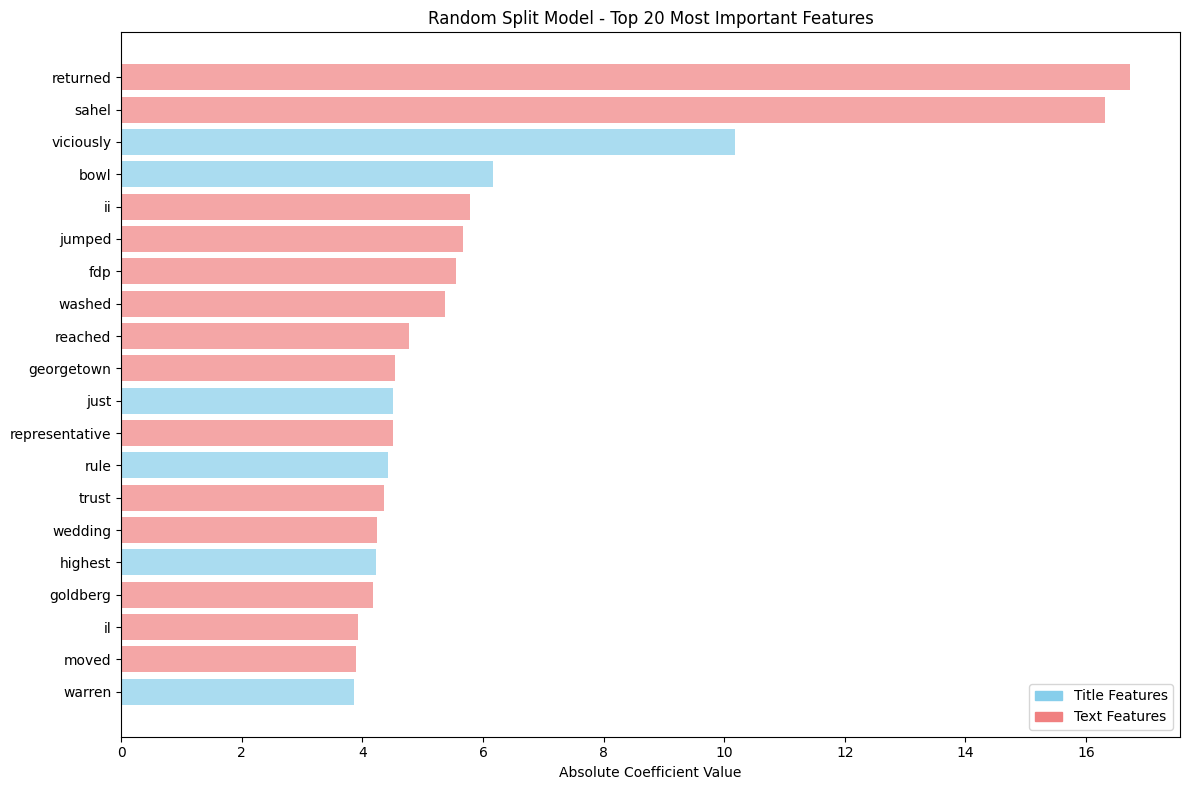


Analyzing Source Split Model...

=== Source Split Model - Feature Importance Analysis ===

Top 10 features predicting Class 1 (positive coefficients):
  text_reuters                   | Coef: 17.7252 | Type: text
  text_said                      | Coef: 15.4970 | Type: text
  title_factbox                  | Coef: 4.5214 | Type: title
  text_wednesday                 | Coef: 4.4109 | Type: text
  text_washington                | Coef: 4.4108 | Type: text
  text_republican                | Coef: 4.1829 | Type: text
  text_tuesday                   | Coef: 4.1042 | Type: text
  title_says                     | Coef: 3.7672 | Type: title
  text_thursday                  | Coef: 3.6554 | Type: text
  text_friday                    | Coef: 3.3464 | Type: text

Top 10 features predicting Class 0 (negative coefficients):
  title_video                    | Coef: -9.4255 | Type: title
  title_breaking                 | Coef: -6.3678 | Type: title
  text_image                     | Coef: -5.708

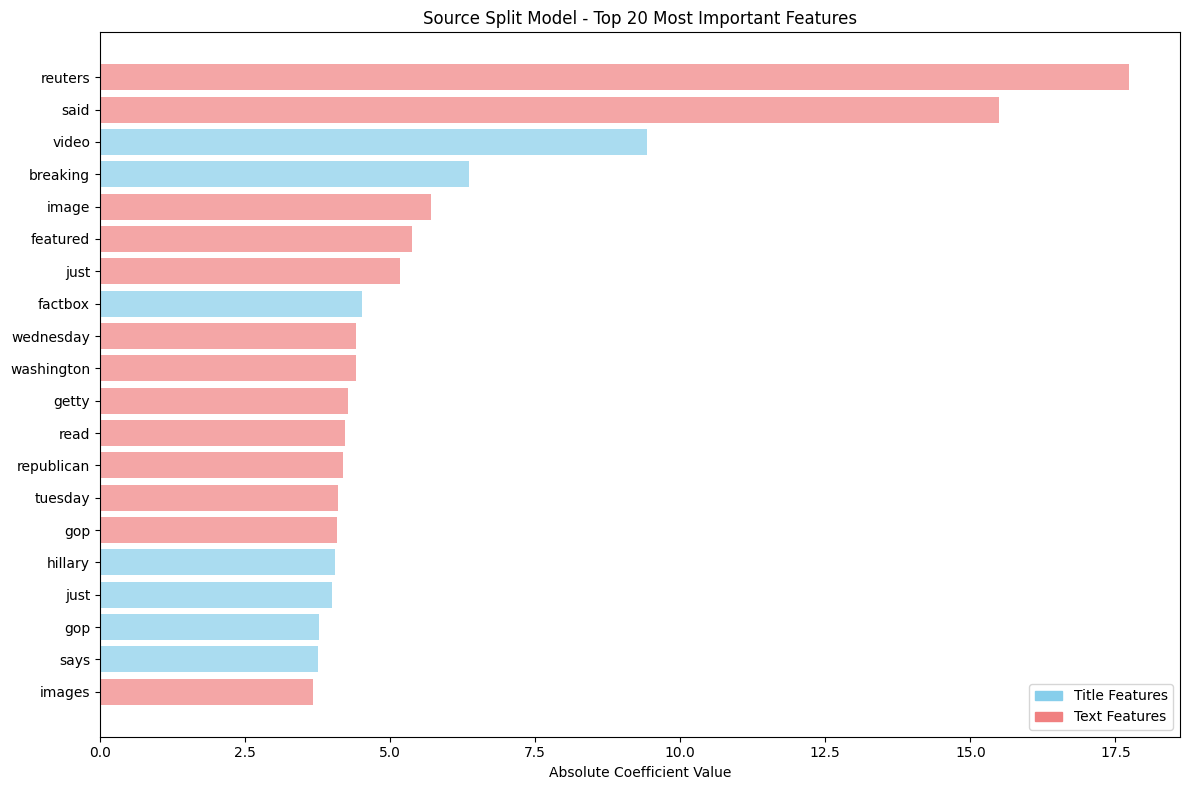


=== Feature Comparison: Random Split vs Source Split ===

Overlapping top features (0 out of 15):

Features important only in Random Split:
  fdp (text)
  georgetown (text)
  ii (text)
  jumped (text)
  reached (text)
  representative (text)
  returned (text)
  sahel (text)
  trust (text)
  washed (text)
  wedding (text)
  bowl (title)
  just (title)
  rule (title)
  viciously (title)

Features important only in Source Split:
  featured (text)
  getty (text)
  gop (text)
  image (text)
  just (text)
  read (text)
  republican (text)
  reuters (text)
  said (text)
  tuesday (text)
  washington (text)
  wednesday (text)
  breaking (title)
  factbox (title)
  video (title)

Feature Overlap: 0.0%

=== Coefficient Distribution Analysis ===


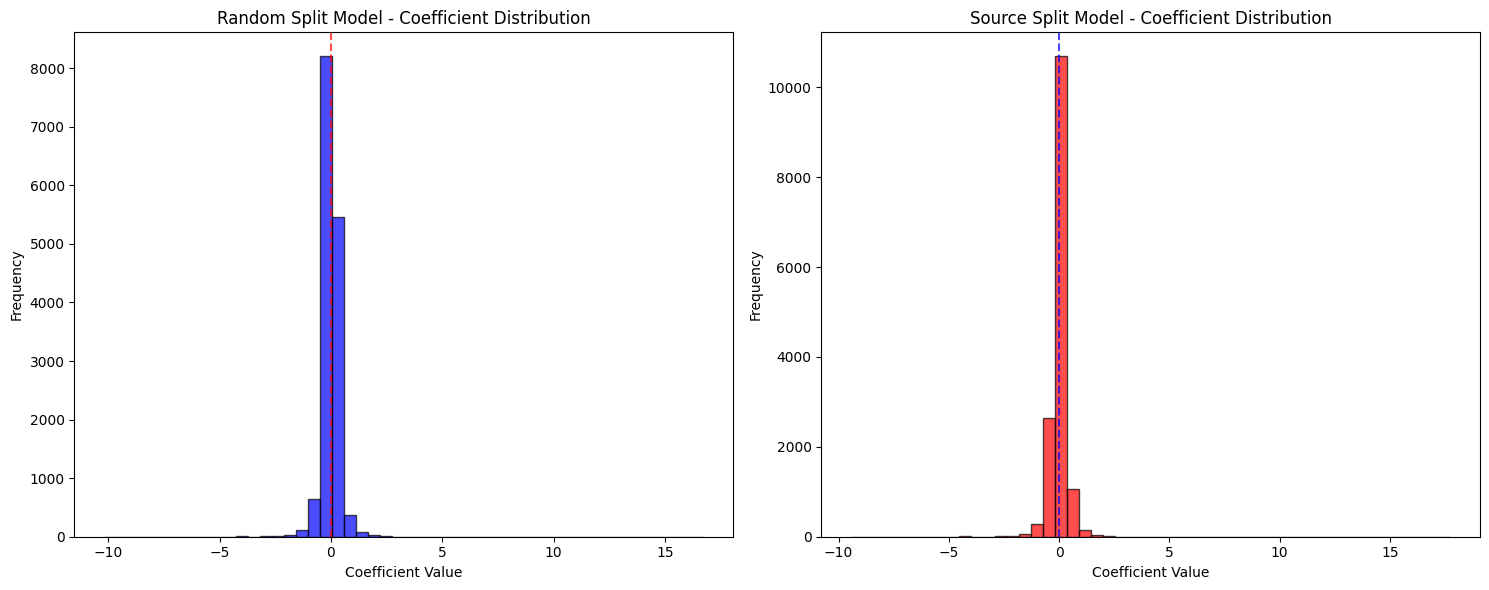

Random Split Model - Coefficient Stats:
  Mean: -0.0191
  Std:  0.4480
  Max:  16.7213
  Min:  -10.1818

Source Split Model - Coefficient Stats:
  Mean: -0.0180
  Std:  0.4415
  Max:  17.7252
  Min:  -9.4255


In [ ]:
# ========================================================================
# Feature Importance Analysis for Both Models
# ========================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_feature_importance(model, tfidf_title, tfidf_text, model_name="Model", top_n=20):
    """
    Analyze and visualize feature importance for logistic regression model
    with combined title and text features.
    """
    
    # Get feature names
    title_features = [f"title_{word}" for word in tfidf_title.get_feature_names_out()]
    text_features = [f"text_{word}" for word in tfidf_text.get_feature_names_out()]
    all_features = title_features + text_features
    
    # Get coefficients (weights) for each class
    coefficients = model.coef_[0]  # For binary classification
    
    # Create DataFrame with features and their importance
    feature_importance = pd.DataFrame({
        'feature': all_features,
        'coefficient': coefficients,
        'abs_coefficient': np.abs(coefficients),
        'feature_type': (['title'] * len(title_features)) + (['text'] * len(text_features))
    })
    
    # Sort by absolute importance
    feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)
    
    print(f"\n=== {model_name} - Feature Importance Analysis ===")
    
    # Top features for each class
    print(f"\nTop {top_n//2} features predicting Class 1 (positive coefficients):")
    top_positive = feature_importance.nlargest(top_n//2, 'coefficient')
    for idx, row in top_positive.iterrows():
        print(f"  {row['feature']:<30} | Coef: {row['coefficient']:.4f} | Type: {row['feature_type']}")
    
    print(f"\nTop {top_n//2} features predicting Class 0 (negative coefficients):")
    top_negative = feature_importance.nsmallest(top_n//2, 'coefficient')
    for idx, row in top_negative.iterrows():
        print(f"  {row['feature']:<30} | Coef: {row['coefficient']:.4f} | Type: {row['feature_type']}")
    
    # Summary statistics
    print(f"\nFeature Type Distribution in Top {top_n} Most Important:")
    top_features = feature_importance.head(top_n)
    type_counts = top_features['feature_type'].value_counts()
    print(f"  Title features: {type_counts.get('title', 0)}")
    print(f"  Text features: {type_counts.get('text', 0)}")
    
    return feature_importance

def plot_feature_importance(feature_importance, model_name="Model", top_n=20):
    """
    Create visualizations for feature importance
    """
    
    # Get top features
    top_features = feature_importance.head(top_n).copy()
    
    # Create color map for feature types
    colors = {'title': 'skyblue', 'text': 'lightcoral'}
    top_features['color'] = top_features['feature_type'].map(colors)
    
    # Clean feature names for display (remove prefix)
    top_features['clean_feature'] = top_features['feature'].str.replace(r'^(title_|text_)', '', regex=True)
    
    # Create horizontal bar plot
    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(top_features)), top_features['abs_coefficient'], 
                    color=top_features['color'], alpha=0.7)
    
    plt.yticks(range(len(top_features)), top_features['clean_feature'])
    plt.xlabel('Absolute Coefficient Value')
    plt.title(f'{model_name} - Top {top_n} Most Important Features')
    plt.gca().invert_yaxis()
    
    # Add legend
    import matplotlib.patches as mpatches
    title_patch = mpatches.Patch(color='skyblue', label='Title Features')
    text_patch = mpatches.Patch(color='lightcoral', label='Text Features')
    plt.legend(handles=[title_patch, text_patch])
    
    plt.tight_layout()
    plt.show()

def compare_model_features(importance_df1, importance_df2, model1_name="Random Split", 
                          model2_name="Source Split", top_n=15):
    """
    Compare top features between two models
    """
    
    print(f"\n=== Feature Comparison: {model1_name} vs {model2_name} ===")
    
    # Get top features from each model
    top1 = set(importance_df1.head(top_n)['feature'])
    top2 = set(importance_df2.head(top_n)['feature'])
    
    # Find overlaps and differences
    common_features = top1.intersection(top2)
    unique_to_model1 = top1 - top2
    unique_to_model2 = top2 - top1
    
    print(f"\nOverlapping top features ({len(common_features)} out of {top_n}):")
    for feature in sorted(common_features):
        clean_name = feature.replace('title_', '').replace('text_', '')
        feature_type = 'title' if feature.startswith('title_') else 'text'
        print(f"  {clean_name} ({feature_type})")
    
    print(f"\nFeatures important only in {model1_name}:")
    for feature in sorted(unique_to_model1):
        clean_name = feature.replace('title_', '').replace('text_', '')
        feature_type = 'title' if feature.startswith('title_') else 'text'
        print(f"  {clean_name} ({feature_type})")
    
    print(f"\nFeatures important only in {model2_name}:")
    for feature in sorted(unique_to_model2):
        clean_name = feature.replace('title_', '').replace('text_', '')
        feature_type = 'title' if feature.startswith('title_') else 'text'
        print(f"  {clean_name} ({feature_type})")
    
    overlap_percentage = len(common_features) / top_n * 100
    print(f"\nFeature Overlap: {overlap_percentage:.1f}%")

# ========================================================================
# Run Analysis on Both Models
# ========================================================================

# Analyze Random Split Model
print("Analyzing Random Split Model...")
importance_random = analyze_feature_importance(
    clf, tfidf_title, tfidf_text, "Random Split Model", top_n=20
)

plot_feature_importance(importance_random, "Random Split Model", top_n=20)

# Analyze Source Split Model  
print("\nAnalyzing Source Split Model...")
importance_source = analyze_feature_importance(
    clf_src, tfidf_title, tfidf_text, "Source Split Model", top_n=20
)

plot_feature_importance(importance_source, "Source Split Model", top_n=20)

# Compare the two models
compare_model_features(importance_random, importance_source, 
                      "Random Split", "Source Split", top_n=15)

# ========================================================================
# Additional Analysis: Coefficient Distribution
# ========================================================================

print("\n=== Coefficient Distribution Analysis ===")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Random Split Model
ax1.hist(importance_random['coefficient'], bins=50, alpha=0.7, color='blue', edgecolor='black')
ax1.set_title('Random Split Model - Coefficient Distribution')
ax1.set_xlabel('Coefficient Value')
ax1.set_ylabel('Frequency')
ax1.axvline(0, color='red', linestyle='--', alpha=0.7)

# Source Split Model
ax2.hist(importance_source['coefficient'], bins=50, alpha=0.7, color='red', edgecolor='black')
ax2.set_title('Source Split Model - Coefficient Distribution')
ax2.set_xlabel('Coefficient Value')
ax2.set_ylabel('Frequency')
ax2.axvline(0, color='blue', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Random Split Model - Coefficient Stats:")
print(f"  Mean: {importance_random['coefficient'].mean():.4f}")
print(f"  Std:  {importance_random['coefficient'].std():.4f}")
print(f"  Max:  {importance_random['coefficient'].max():.4f}")
print(f"  Min:  {importance_random['coefficient'].min():.4f}")

print(f"\nSource Split Model - Coefficient Stats:")
print(f"  Mean: {importance_source['coefficient'].mean():.4f}")
print(f"  Std:  {importance_source['coefficient'].std():.4f}")
print(f"  Max:  {importance_source['coefficient'].max():.4f}")
print(f"  Min:  {importance_source['coefficient'].min():.4f}")

# Model Analysis: Critical Findings and Next Steps

## Executive Summary

Despite extensive data cleaning efforts, our feature importance analysis has revealed fundamental issues with the dataset that explain the suspiciously high model performance (98.8% accuracy). The models appear to be learning source-specific artifacts rather than semantic indicators of news authenticity.

## Key Findings

### 🚨 Critical Issues Identified

**1. Complete Feature Divergence Between Models**
- **0% overlap** between top 10 most important features across random vs. source-based splits
- This indicates models are learning fundamentally different patterns rather than generalizable classification rules
- Suggests underlying data structure problems that persist despite cleaning

**2. Source-Specific Pattern Learning**

**Source Split Model** (learning publication metadata):
- `text_reuters` (coef: 17.73) - Clear news organization identifier
- Day references (`wednesday`, `tuesday`, `thursday`, `friday`) - Publication timing artifacts
- `title_factbox` - Reuters-specific content formatting
- Political terminology (`republican`, `washington`) - Legitimate news vocabulary

**Random Split Model** (learning content artifacts):
- `text_returned` (coef: 16.72) - Unexpectedly high coefficient for common word
- Geographic specificity (`text_sahel`) - Highly specific regional references
- Sensationalized language (`title_viciously`) in negative coefficients
- Random semantic clusters (`washed`, `wedding`, `throw`) with high importance

**3. Statistical Red Flags**
- Coefficient magnitudes of 16-17 are unusually extreme for text classification
- Similar coefficient distributions (std ~0.44) despite completely different feature sets
- High performance maintained across different data splits suggests systematic bias

## Interpretation

### What the Models Are Actually Learning

**Class 1 (Likely "Real News"):**
- Professional journalism language and structure
- Formal news organization content (Reuters, AP-style writing)
- Standard news reporting conventions and timing

**Class 0 (Likely "Fake News"):**
- Different publication formats (videos, social media posts and comments)
- Non-traditional news language patterns
- Sensationalized or informal content structure

### Root Cause Analysis

The models are functioning as **source classifiers** rather than **content authenticity classifiers**. Even after extensive cleaning, the fundamental issue appears to be that:
- "Real news" examples come primarily from established news organizations
- "Fake news" examples come from different platforms/sources with distinct linguistic patterns
- The classification task has become "professional journalism vs. other content types"

## Future Steps to Take

### 1. Dataset Composition Analysis
- **Audit source distribution**: Examine the actual distribution of news sources/publishers across both classes
- **Content type analysis**: Investigate how much of Class 0 contains varied content formats (social media posts, video comments, opinionated pieces)
- **Temporal analysis**: Check if articles from different time periods cluster in different classes

### 2. Alternative Labeling Verification
- **Cross-reference with fact-checking databases**: Validate labels against Snopes, PolitiFact, or similar sources
- **Manual sample review**: Randomly sample 100-200 articles from each class for manual authenticity assessment
- **Inter-annotator agreement**: Have multiple reviewers assess a subset to measure labeling consistency

### 3. Feature Engineering Refinements
- **Remove publication artifacts**: Strip out other source indicators (Reuters tags, AP formatting, etc.)
- **Normalize content structure**: Standardize article formatting to focus on semantic content

### 4. Alternative Modeling Approaches
- **Semantic similarity analysis**: Use embeddings (BERT, RoBERTa) to focus on meaning rather than surface-level patterns

### 5. Evaluation Strategy Overhaul
- **Domain adaptation testing**: Evaluate performance on completely different news domains/topics
- **Adversarial testing**: Create test sets designed to challenge source-based classification
- **Temporal robustness**: Test on articles from different time periods than training data

## Success Metrics for Next Phase

- **Feature overlap > 50%** between different model splits
- **Performance degradation < 10%** when source artifacts are removed
- **Manual validation accuracy > 90%** to confirm that humans agree with model predictions

## Conclusion

While the high accuracy initially appeared promising, the feature analysis reveals that our models are solving an easier proxy task rather than the intended fake news detection problem. The next phase must focus on ensuring the models learn semantic authenticity indicators rather than source-specific formatting patterns. This feature analysis illustrates how critical it is to verify whether accuracy inflation occured via invalid or dataset-specific artifacts and serves as a reminder to inspect and explore the dataset examples thoroughly.